## Lambda rank

In [1]:
import pickle
from typing import List, Tuple

import numpy as np
import torch
from catboost.datasets import msrank_10k
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from tqdm.auto import tqdm


class Solution:
    """
    Сlass creates a gradient boosting model based on Lambda calculation, 
    trains and validates it.
    """
    def __init__(
        self, 
        n_estimators: int = 100, 
        lr: float = 0.5, 
        ndcg_top_k: int = 10,
        subsample: float = 0.6, 
        colsample_bytree: float = 0.9,
        max_depth: int = 5, 
        min_samples_leaf: int = 8,
    ):
        """
        Args:
            n_estimators (int): Number of epochs.
            lr (float): Learning rate.
            ndcg_top_k (int): NDCG metric score for top k.
            subsample (float): The proportion of objects from the sample on which each tree is trained.
            colsample_bytree (float): The proportion of features from the sample on which each tree is trained.
            max_depth (int): Tree building depth.
            min_samples_leaf (int): The minimum number in the terminal (final) leaves of the tree.
        """
        self._prepare_data()
        self.ndcg_top_k = ndcg_top_k
        self.ndcg_scheme = "exp2"
        self.n_estimators = n_estimators
        self.lr = lr
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.subsample = subsample
        self.colsample_bytree = colsample_bytree
        
        self.n_objects_train, self.n_features_ = self.X_train.size()
        self.n_objects_test = self.X_test.size()[0]
        self.n_subsample = int(self.n_objects_train * self.subsample)
        self.n_subfeatures = int(self.n_features_ * self.colsample_bytree)
        
        self.trees = [
            DecisionTreeRegressor(
                max_depth=self.max_depth,
                min_samples_leaf=self.min_samples_leaf,
                random_state=i,
            ) 
            for i in range(self.n_estimators)
        ]
        self.tree_features = []
        self.train_ndsgs = []
        self.test_ndcgs = []
        self.best_ndcg = -1
        self.best_idx = -1

    def _get_data(self) -> List[np.ndarray]:
        """
        Method loads data for training and test.
        """
        train_df, test_df = msrank_10k()

        X_train = train_df.drop([0, 1], axis=1).values
        y_train = train_df[[0]].values
        query_ids_train = train_df[1].values.astype(int)

        X_test = test_df.drop([0, 1], axis=1).values
        y_test = test_df[[0]].values
        query_ids_test = test_df[1].values.astype(int)

        return [X_train, y_train, query_ids_train, X_test, y_test, query_ids_test]

    def _prepare_data(self) -> None:
        """
        Method prepares data for training and test.
        """
        (X_train, y_train, self.query_ids_train,
            X_test, y_test, self.query_ids_test) = self._get_data()
        X_train = self._scale_features_in_query_groups(X_train, self.query_ids_train)
        X_test = self._scale_features_in_query_groups(X_test, self.query_ids_test)
        self.X_train, self.ys_train, self.X_test, self.ys_test = map(torch.FloatTensor,
                                                                    [X_train, y_train, X_test, y_test])
        self.query_ids_train_u = np.unique(self.query_ids_train)
        self.query_ids_test_u = np.unique(self.query_ids_test)


    def _scale_features_in_query_groups(
            self, 
            inp_feat_array: np.ndarray,
            inp_query_ids: np.ndarray
    ) -> np.ndarray:
        """
        Method normalizes the input data.
        """
        result = []
        for q_id in np.unique(inp_query_ids):
            result.append(StandardScaler().fit_transform(inp_feat_array[inp_query_ids == q_id]))
        return np.vstack(result)  

    def _train_one_tree(
        self, 
        cur_tree_idx: int, 
        train_preds: torch.FloatTensor
    ) -> Tuple[DecisionTreeRegressor, np.ndarray]:
        """
        Method for training one tree.
        """
        lambdas = torch.zeros(self.n_objects_train, 1)
        
        for query_id in self.query_ids_train_u:
            idx_q = self.query_ids_train == query_id
            lambdas[idx_q] = self._compute_lambdas(self.ys_train[idx_q], train_preds[idx_q])
        
        idx_sample = np.random.choice(self.n_objects_train, self.n_subsample, replace=False)
        feature_sample = np.random.choice(self.n_features_, self.n_subfeatures, replace=False)
        
        regressor = self.trees[cur_tree_idx]
        regressor.fit(self.X_train[idx_sample, :][:, feature_sample], -lambdas[idx_sample])
        
        return regressor, feature_sample

    def _calc_data_ndcg(
            self, 
            queries_list: np.ndarray,
            true_labels: torch.FloatTensor, 
            preds: torch.FloatTensor
    ) -> float:
        """
        Method for calculating data NDCG.
        """
        with torch.no_grad():
            ndcgs = []
            for query_id in np.unique(queries_list):
                idx_q = queries_list == query_id
                ndcg = self._ndcg_k(true_labels[idx_q], preds[idx_q], self.ndcg_top_k)
                if np.isnan(ndcg):
                    ndcg = 0
                ndcgs.append(ndcg)        
        return np.mean(ndcgs)
    
    def fit(self) -> None:
        """
        Method for training k trees and find the best NDCG score and tree id.
        """
        np.random.seed(0)
        
        train_preds = torch.zeros(self.n_objects_train, 1)
        test_preds = torch.zeros(self.n_objects_test, 1)
        
        for idx_tree in tqdm(range(self.n_estimators)):
            tree, feature_sample = self._train_one_tree(idx_tree, train_preds)
            self.trees.append(tree)
            self.tree_features.append(feature_sample)
            
            X_train_cur = self.X_train[:, feature_sample]
            train_preds += self.lr * torch.FloatTensor(tree.predict(X_train_cur)).reshape(-1, 1)
            train_ndcg = self._calc_data_ndcg(self.query_ids_train, self.ys_train, train_preds)
            self.test_ndcgs.append(train_ndcg)
            
            X_test_cur = self.X_test[:, feature_sample]
            test_preds += self.lr * torch.FloatTensor(tree.predict(X_test_cur)).reshape(-1, 1)
            test_ndcg = self._calc_data_ndcg(self.query_ids_test, self.ys_test, test_preds)
            self.test_ndcgs.append(test_ndcg)
            
            if test_ndcg > self.best_ndcg:
                self.best_ndcg = test_ndcg
                # print(self.best_ndcg)
                self.best_idx = idx_tree
        
        self.trees = self.trees[:self.best_idx+1]
        self.tree_features = self.tree_features[:self.best_idx+1]
        self.train_ndsgs = self.test_ndcgs[:self.best_idx+1]
        self.test_ndsgs = self.test_ndcgs[:self.best_idx+1]

    def predict(self, data: torch.FloatTensor) -> torch.FloatTensor:
        """
        Method for making prediction.
        """
        preds = torch.zeros(data.shape[0], 1)
        for tree, features in zip(self.trees, self.tree_features):
            preds += self.lr * tree.predict(data[:, features]).reshape(-1, 1)
        return preds

    def _compute_lambdas(self, y_true: torch.FloatTensor, y_pred: torch.FloatTensor) -> torch.FloatTensor:
        """
        Method for computing lambdas.
        """
        # рассчитаем нормировку, IdealDCG
        ideal_dcg = self._dcg_k(y_true, y_true, self.ndcg_scheme)
        
        if ideal_dcg:
            N = 1 / ideal_dcg
        else:
            N = 0.0

        # рассчитаем порядок документов согласно оценкам релевантности
        _, rank_order = torch.sort(y_true, descending=True, axis=0)
        rank_order += 1

        with torch.no_grad():
            # получаем все попарные разницы скоров в батче
            pos_pairs_score_diff = 1.0 + torch.exp((y_pred - y_pred.t()))
            # поставим разметку для пар, 1 если первый документ релевантнее
            # -1 если второй документ релевантнее
            Sij = self._compute_labels_in_batch(y_true)
            # посчитаем изменение gain из-за перестановок
            gain_diff = self._compute_gain_diff(y_true, self.ndcg_scheme)
            # посчитаем изменение знаменателей-дискаунтеров
            decay_diff = (1.0 / torch.log2(rank_order + 1.0)) - (1.0 / torch.log2(rank_order.t() + 1.0))
            # посчитаем непосредственное изменение nDCG
            delta_ndcg = torch.abs(N * gain_diff * decay_diff)
            # посчитаем лямбды
            lambda_update =  (0.5 * (1 - Sij) - 1 / pos_pairs_score_diff) * delta_ndcg
            lambda_update = torch.sum(lambda_update, dim=1, keepdim=True)

        return lambda_update
        
    def _compute_labels_in_batch(self, y_true:torch.Tensor) -> torch.Tensor:
        """
        Method compute_labels_in_batch.
        """
        # разница релевантностей каждого с каждым объектом
        rel_diff = y_true - y_true.t()

        # 1 в этой матрице - объект более релевантен
        pos_pairs = (rel_diff > 0).type(torch.float32)

        # 1 тут - объект менее релевантен
        neg_pairs = (rel_diff < 0).type(torch.float32)
        Sij = pos_pairs - neg_pairs
        return Sij
    
    def _compute_gain_diff(self, y_true: torch.Tensor, gain_scheme: str) -> torch.Tensor:
        """
        Method for calculating gain diff.
        """
        if gain_scheme == "exp2":
            gain_diff = torch.pow(2.0, y_true) - torch.pow(2.0, y_true.t())
        elif gain_scheme == "diff":
            gain_diff = y_true - y_true.t()
        else:
            raise ValueError(f"{gain_scheme} gain method not supported")
        return gain_diff

    def _compute_gain(self, y_value: float, gain_scheme: str) -> float:
        """
        Method for calculating DCG and NDCG, which calculates Gain.
        """
        if gain_scheme == "const":
            return y_value
        elif gain_scheme == "exp2":
            return 2**y_value - 1
        else:
            raise ValueError(f"{gain_scheme} gain method not supported")
                          
    def _dcg_k(
        self, 
        ys_true: torch.Tensor, 
        ys_pred: torch.Tensor, 
        gain_scheme: str = "exp2", 
        k: int = None
    ) -> float:
        """
        Method to calculate the DCG at k. 
        https://en.wikipedia.org/wiki/Discounted_cumulative_gain
        
        Args:
            ys_true (torch.Tensor): Tensor of actual relevancy values.
            ys_pred (torch.Tensor): Tensor of predicted relevancy values.
            gain_scheme (str): Gain scheme.
            k (int) : Choose highest k scores in the ranking.

        Returns:
            torch.Tensor: DCG at k metric.
        """
        order = torch.argsort(ys_pred, descending=True, dim=0)
        true_sorted_by_preds = torch.gather(ys_true, dim=0, index=order)

        gain_function = lambda x: self._compute_gain(x, gain_scheme)
        gains = gain_function(true_sorted_by_preds)

        discounts = torch.tensor(1) /  torch.log2(torch.arange(true_sorted_by_preds.shape[0], dtype=torch.double) + 2.0).unsqueeze(-1)
        if k is not None:
            discounts[k:] = 0
        discounted_gains = gains * discounts

        sum_dcg = torch.sum(discounted_gains, dim=0)
        return float(sum_dcg)
                          
    def _ndcg_k(
        self, 
        ys_true: torch.Tensor, 
        ys_pred: torch.Tensor, 
        ndcg_top_k: int,
    ) -> float:
        """
        Method to calculate the NDCG at k. 
        https://en.wikipedia.org/wiki/Discounted_cumulative_gain
        
        Args:
            ys_true (torch.Tensor): Tensor of actual relevancy values.
            ys_pred (torch.Tensor): Tensor of predicted relevancy values.
            gain_scheme (str): Gain scheme.
            k (int) : Choose highest k scores in the ranking.

        Returns:
            torch.Tensor: NDCG at k metric.
        """
        ideal_dcgs = self._dcg_k(ys_true, ys_true, self.ndcg_scheme, ndcg_top_k)
        predicted_dcgs = self._dcg_k(ys_true, ys_pred, self.ndcg_scheme, ndcg_top_k)
        if ideal_dcgs == 0:
            return 0
        return predicted_dcgs/ ideal_dcgs
    
    def save_model(self, path: str) -> None:
        """
        Method saves the model.
        
        Args:
            path (str): Path to model.
        """
        state = {
            "trees" : self.trees,
            "tree_features" : self.tree_features,
            "best_ndcg": self.best_ndcg,
            "best_idx": self.best_idx,
            "lr": self.lr
        }
        with open(path, "wb") as output_file:
            pickle.dump(state, output_file)

    def load_model(self, path: str) -> None:
        """
        Method loads the model.
        
        Args:
            path (str): Path to model.
        """
        with open(path, "rb") as input_file:
            state = pickle.load(input_file)
        self.trees = state["trees"]
        self.tree_features = state["tree_features"]
        self.best_ndcg = state["best_ndcg"]
        self.best_idx = state["best_idx"]
        self.lr = state["lr"]

In [2]:
# with best params
model = Solution( 
        lr=0.514863, 
        subsample=0.419661, 
        colsample_bytree=0.937201,
        max_depth=30, 
        min_samples_leaf=14
)

In [3]:
model.fit()

  0%|          | 0/100 [00:00<?, ?it/s]

In [5]:
model.best_ndcg, model.best_idx

(0.43711583807783116, 69)

In [6]:
model.save_model("./model.pkl")

In [7]:
model.load_model("./model.pkl")

In [8]:
pred = model.predict(model.X_test)

In [9]:
model._calc_data_ndcg(model.query_ids_test, model.ys_test, pred)

0.43711583807783116

## Find best params with Hyperopt

https://www.kaggle.com/code/donkeys/exploring-hyperopt-parameter-tuning

array([[<AxesSubplot:title={'center':'var1'}>]], dtype=object)

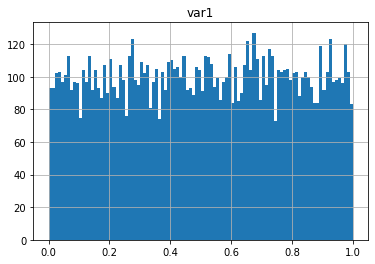

In [12]:
low = 0
high = 1
values = []
space = hp.uniform('something', low, high)
for x in range(10000):
    values.append(hyperopt.pyll.stochastic.sample(space))
df = pd.DataFrame(values, columns=["var1"])
df.hist(bins=100)

In [12]:
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
import hyperopt
import pandas as pd
from functools import partial

search_space = {
    # 'criterion': hp.choice('criterion', ["squared_error", "friedman_mse", "absolute_error"]),
    'lr': hp.uniform("lr", 0, 1),
    # 'lr':  hp.choice("lr", np.arange(0.01, 1, 0.01)),
    'subsample': hp.uniform("subsample", 0, 1),
    # 'subsample': hp.choice("subsample", np.arange(0.3, 1, 0.01)),
    'colsample_bytree': hp.uniform("colsample_bytree", 0, 1),
    # 'colsample_bytree': hp.choice("colsample_bytree", np.arange(0.2, 1, 0.01)),
    'max_depth' :  hp.choice('max_depth', range(1,31)),
    'min_samples_leaf' : hp.choice('min_samples_leaf', range(1,21)),
}

def objective(params):
    model = Solution(**params)
    model.fit()
    # возвращаем результаты, которые записываются в Trials()
    return   {'loss': -model.best_ndcg, 'params': params, 'status': STATUS_OK}

In [13]:
# запускаем hyperopt
trials = Trials()
best = fmin( 
          # функция для оптимизации  
            fn=objective,
          # пространство поиска гиперпараметров  
            space=search_space,
          # алгоритм поиска
            algo=tpe.suggest,
          # число итераций 
          # (можно ещё указать и время поиска) 
            max_evals=40,
          # куда сохранять историю поиска
            trials=trials,
          # random state
            rstate=np.random.default_rng(1),
          # progressbar
            show_progressbar=True,
        )

  0%|                                                                           | 0/40 [00:00<?, ?trial/s, best loss=?]

  0%|          | 0/100 [00:00<?, ?it/s]

  2%|█▏                                               | 1/40 [00:26<17:28, 26.87s/trial, best loss: -0.368882469460574]

  0%|          | 0/100 [00:00<?, ?it/s]

  5%|██▍                                              | 2/40 [00:46<14:19, 22.61s/trial, best loss: -0.368882469460574]

  0%|          | 0/100 [00:00<?, ?it/s]

  8%|███▋                                             | 3/40 [02:46<41:27, 67.22s/trial, best loss: -0.368882469460574]

  0%|          | 0/100 [00:00<?, ?it/s]

 10%|████▊                                           | 4/40 [04:24<47:26, 79.08s/trial, best loss: -0.4120340848410301]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|██████                                          | 5/40 [04:54<35:51, 61.48s/trial, best loss: -0.4120340848410301]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|███████▏                                        | 6/40 [06:56<46:27, 82.00s/trial, best loss: -0.4120340848410301]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|████████▍                                       | 7/40 [07:51<40:14, 73.16s/trial, best loss: -0.4120340848410301]

  0%|          | 0/100 [00:00<?, ?it/s]

 20%|█████████▌                                      | 8/40 [08:28<33:00, 61.88s/trial, best loss: -0.4120340848410301]

  0%|          | 0/100 [00:00<?, ?it/s]

 22%|██████████▊                                     | 9/40 [09:40<33:36, 65.06s/trial, best loss: -0.4120340848410301]

  0%|          | 0/100 [00:00<?, ?it/s]

 25%|███████████▊                                   | 10/40 [10:00<25:29, 50.98s/trial, best loss: -0.4120340848410301]

  0%|          | 0/100 [00:00<?, ?it/s]

 28%|████████████▉                                  | 11/40 [10:23<20:34, 42.57s/trial, best loss: -0.4120340848410301]

  0%|          | 0/100 [00:00<?, ?it/s]

 30%|██████████████                                 | 12/40 [11:06<19:56, 42.73s/trial, best loss: -0.4120340848410301]

  0%|          | 0/100 [00:00<?, ?it/s]

 32%|██████████████▉                               | 13/40 [12:08<21:46, 48.37s/trial, best loss: -0.43711583807783116]

  0%|          | 0/100 [00:00<?, ?it/s]

 35%|████████████████                              | 14/40 [13:11<22:57, 52.97s/trial, best loss: -0.43711583807783116]

  0%|          | 0/100 [00:00<?, ?it/s]

 38%|█████████████████▎                            | 15/40 [13:31<17:51, 42.88s/trial, best loss: -0.43711583807783116]

  0%|          | 0/100 [00:00<?, ?it/s]

 40%|██████████████████▍                           | 16/40 [14:14<17:10, 42.95s/trial, best loss: -0.43711583807783116]

  0%|          | 0/100 [00:00<?, ?it/s]

 42%|███████████████████▌                          | 17/40 [14:32<13:36, 35.51s/trial, best loss: -0.43711583807783116]

  0%|          | 0/100 [00:00<?, ?it/s]

 45%|████████████████████▋                         | 18/40 [15:15<13:47, 37.60s/trial, best loss: -0.43711583807783116]

  0%|          | 0/100 [00:00<?, ?it/s]

 48%|█████████████████████▊                        | 19/40 [16:40<18:12, 52.02s/trial, best loss: -0.43711583807783116]

  0%|          | 0/100 [00:00<?, ?it/s]

 50%|███████████████████████                       | 20/40 [16:59<13:58, 41.92s/trial, best loss: -0.43711583807783116]

  0%|          | 0/100 [00:00<?, ?it/s]

 52%|████████████████████████▏                     | 21/40 [17:41<13:17, 41.97s/trial, best loss: -0.43711583807783116]

  0%|          | 0/100 [00:00<?, ?it/s]

 55%|█████████████████████████▎                    | 22/40 [18:49<14:58, 49.93s/trial, best loss: -0.43711583807783116]

  0%|          | 0/100 [00:00<?, ?it/s]

 57%|██████████████████████████▍                   | 23/40 [19:09<11:33, 40.81s/trial, best loss: -0.43711583807783116]

  0%|          | 0/100 [00:00<?, ?it/s]

 60%|███████████████████████████▌                  | 24/40 [19:54<11:16, 42.28s/trial, best loss: -0.43711583807783116]

  0%|          | 0/100 [00:00<?, ?it/s]

 62%|████████████████████████████▊                 | 25/40 [20:40<10:50, 43.38s/trial, best loss: -0.43711583807783116]

  0%|          | 0/100 [00:00<?, ?it/s]

 65%|█████████████████████████████▉                | 26/40 [20:58<08:19, 35.71s/trial, best loss: -0.43711583807783116]

  0%|          | 0/100 [00:00<?, ?it/s]

 68%|███████████████████████████████               | 27/40 [21:50<08:47, 40.60s/trial, best loss: -0.43711583807783116]

  0%|          | 0/100 [00:00<?, ?it/s]

 70%|████████████████████████████████▏             | 28/40 [22:35<08:21, 41.79s/trial, best loss: -0.43711583807783116]

  0%|          | 0/100 [00:00<?, ?it/s]

 72%|█████████████████████████████████▎            | 29/40 [23:29<08:19, 45.40s/trial, best loss: -0.43711583807783116]

  0%|          | 0/100 [00:00<?, ?it/s]

 75%|██████████████████████████████████▌           | 30/40 [24:31<08:24, 50.48s/trial, best loss: -0.43711583807783116]

  0%|          | 0/100 [00:00<?, ?it/s]

 78%|███████████████████████████████████▋          | 31/40 [25:27<07:49, 52.13s/trial, best loss: -0.43711583807783116]

  0%|          | 0/100 [00:00<?, ?it/s]

 80%|████████████████████████████████████▊         | 32/40 [25:48<05:41, 42.71s/trial, best loss: -0.43711583807783116]

  0%|          | 0/100 [00:00<?, ?it/s]

 82%|█████████████████████████████████████▉        | 33/40 [26:08<04:11, 35.89s/trial, best loss: -0.43711583807783116]

  0%|          | 0/100 [00:00<?, ?it/s]

 85%|███████████████████████████████████████       | 34/40 [27:10<04:22, 43.79s/trial, best loss: -0.43711583807783116]

  0%|          | 0/100 [00:00<?, ?it/s]

 88%|████████████████████████████████████████▎     | 35/40 [28:25<04:26, 53.23s/trial, best loss: -0.43711583807783116]

  0%|          | 0/100 [00:00<?, ?it/s]

 90%|█████████████████████████████████████████▍    | 36/40 [29:02<03:13, 48.36s/trial, best loss: -0.43711583807783116]

  0%|          | 0/100 [00:00<?, ?it/s]

 92%|██████████████████████████████████████████▌   | 37/40 [29:33<02:09, 43.01s/trial, best loss: -0.43711583807783116]

  0%|          | 0/100 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████▋  | 38/40 [29:57<01:14, 37.49s/trial, best loss: -0.43711583807783116]

  0%|          | 0/100 [00:00<?, ?it/s]

 98%|████████████████████████████████████████████▊ | 39/40 [31:34<00:55, 55.16s/trial, best loss: -0.43711583807783116]

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████| 40/40 [32:09<00:00, 48.24s/trial, best loss: -0.43711583807783116]


In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

def df_results(hp_results: dict) -> pd.DataFrame:
    """
    Display Hyperopt results in DataFrame.
    
    Args:
        hp_results (dict): Hyperopt results.
    Returns:
        pd.DataFrame
    """ 

    results = pd.DataFrame([{**x, **x['params']} for x in  hp_results])
    results.drop(labels=['status', 'params'], axis=1, inplace=True)
    results.sort_values(by=['loss'], ascending=True, inplace=True)
    return results

results = df_results(trials.results)

In [15]:
results

,loss,colsample_bytree,lr,max_depth,min_samples_leaf,subsample
12,-0.437116,0.937201,0.514863,30,14,0.419661
29,-0.430935,0.913301,0.385164,16,20,0.519452
28,-0.425236,0.822866,0.413698,16,20,0.465233
26,-0.422326,0.804991,0.446986,16,11,0.433352
33,-0.415174,0.877650,0.721568,8,20,0.807154
38,-0.414831,0.848599,0.688619,24,8,0.790778
21,-0.413442,0.997894,0.157043,25,7,0.377997
3,-0.412034,0.867019,0.258968,25,14,0.823266
36,-0.412010,0.277271,0.622270,11,14,0.544466
34,-0.411975,0.698171,0.847418,12,9,0.980202
